Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from time import time

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return tf.compat.as_str(f.read(name))
    f.close()

text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


In [4]:
print(text[:63])
print(text[-63:])

 anarchism originated as a term of abuse first used against ear
extensively excavated in one nine six three one nine six five b


In [5]:
text = text.strip()
len(text)

99999999

In [6]:
text[1002]

' '

Create a small validation set.

In [7]:
valid_text = text[:1003].strip()  # to monitor performance during training
valid_size = len(valid_text)
train_text = text[1003:].strip()
train_size = len(train_text)

print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99998996 anarchists advocate social relations based upon voluntary associ
1002 anarchism originated as a term of abuse first used against early


Utility functions to map characters to vocabulary IDs and back.

In [8]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
    return 0

def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [9]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]
        self._last_batch = self._next_batch()  # the last batch is to be predicted
  
    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, char2id(self._text[self._cursor[b]])] = 1.0
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
  
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['anarchists ', ' military g', 'ia arches n', 'eys and mon', 'ied urraca ', 'and richard', 'd liturgica', 'pened for p', ' from the n', 'ation took ', 'york other ', 'oeing seven', 'sted with a', ' has probab', ' made to re', 'who receive', 'significant', 'erce critic', ' six eight ', 'totle s unc', 'can be lost', ' intracellu', ' of the siz', 'o pass him ', 'rtain drugs', 't will take', 'nvince the ', 'told him to', 'ign and bar', ' side stand', ' texts such', 'pitalize on', 'plicate of ', 'nn es d hiv', 'january eig', ' zero the l', 'theories cl', 'instance th', 'ensional an', ' holy mormo', 'support or ', ' still disa', 'cillating s', 'ght subtype', 'taly langua', 'e tower com', 'oma press o', 'ise linux s', 'ecomes the ', 'n a nazi co', 'fabian soci', 'y to relati', 'rman networ', ' emperor hi', ' in politic', 'o latin mos', 'isky risker', 'clopedic ov', 'e the air c', 'ing from ac', 't grid cent', 'ns more tha', 'al of devot', 'ave made su']
[' advocate s', 'governments', 'nationa

In [17]:
## Helper functions
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10  # avoid -log(p) prone to infinity
    return np.sum(labels * -np.log(predictions)) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a probability distribution assumed to be an 
    normalized array (sum to 1).
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    return b/np.sum(b, 1)[:,None]

def weight_init(n_in, n_out, width=0.1):
    return tf.Variable(tf.truncated_normal([n_in, n_out], -width, width))

def bias_init(num_nodes):
    return tf.Variable(tf.zeros([1, num_nodes]))

Simple LSTM Model.

In [11]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
    
    # Parameters:
    # Input gate: input, previous output, and bias.
    ix = weight_init(vocabulary_size, num_nodes)
    im = weight_init(num_nodes, num_nodes)
    ib = bias_init(num_nodes)
    # Forget gate: input, previous output, and bias.
    fx = weight_init(vocabulary_size, num_nodes)
    fm = weight_init(num_nodes, num_nodes)
    fb = bias_init(num_nodes)
    # Memory cell: input, state and bias.                             
    cx = weight_init(vocabulary_size, num_nodes)
    cm = weight_init(num_nodes, num_nodes)
    cb = bias_init(num_nodes)
    # Output gate: input, previous output, and bias.
    ox = weight_init(vocabulary_size, num_nodes)
    om = weight_init(num_nodes, num_nodes)
    ob = bias_init(num_nodes)
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = weight_init(num_nodes, vocabulary_size)
    b = bias_init(vocabulary_size)

    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        #logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
        logits = tf.matmul(tf.concat(0, outputs), w) + b
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits, tf.concat(0, train_labels)))

    # Optimizer.
    # note: 
    #   tf.train.optimizer.minimize() same as 
    #   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)  
    
    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])  # one sample character
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [12]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            
            perp_loss = float(np.exp(mean_loss))
            print('Minibatch perplexity (from avg loss): %.2f' % perp_loss)
            perp_loss_log.append(perp_loss)
            mean_loss = 0
            
            labels = np.concatenate(list(batches)[1:])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity (from preds-labels): %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 3.296984, learning rate: 10.000000
Minibatch perplexity (from avg loss): 27.03
Minibatch perplexity (from preds-labels): 27.03
 opohajdmpemvohwmdwant ctlktgqtut  livigmleclfrr zhnts grfo origeozofieydebzoibk
ir i w tcooeauhptkcabchd uopeoboxsxwxpeohiiyphrnadehcnjw tmt qoapazeurceklapkhle
y vn la ilulonewzmtfafkb n nogjnmovowumia  pexh absu irwihucgel arh gtnsrb mqfra
qiytqwvcapaggmrsjthfmcnjto faudemv oe sebvsljozaulzdjtuzvliphdcjipilb ro nsliah 
rmfj ux  etsho cbi n yi b gsef jqxku eiaoiydbpoaorir abraer arfpwbhrjcs runr sdk
Validation set perplexity: 20.21
Average loss at step 100: 2.596293, learning rate: 10.000000
Minibatch perplexity (from avg loss): 13.41
Minibatch perplexity (from preds-labels): 11.31
Validation set perplexity: 10.43
Average loss at step 200: 2.247800, learning rate: 10.000000
Minibatch perplexity (from avg loss): 9.47
Minibatch perplexity (from preds-labels): 8.58
Validation set perplexity: 8.65
Average los

In [37]:
def plot_log(loss_log, perp_log, val_perp_log):
    pylab.style.use('ggplot')
    f, (ax1, ax2) = pylab.subplots(1, 2, figsize=(14,6))
    ax1.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
    ax1.plot(summary_frequency*(np.arange(len(val_perp_log))+1), val_perp_log, 'r-', label='val_perp')
    ax1.set_xlabel('Training step')
    ax1.set_ylabel('Perplexity')
    ax1.legend(loc='best')

    line1 = ax2.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
    ax2.set_xlabel('Training step')
    ax2.set_ylabel('Perplexity')
    ax3 = ax2.twinx()
    line2 = ax3.plot(summary_frequency*(np.arange(len(loss_log))+1), loss_log, 'r-', label='batch_loss')
    ax3.set_ylabel('Loss')
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc='best')
    
    pylab.show()

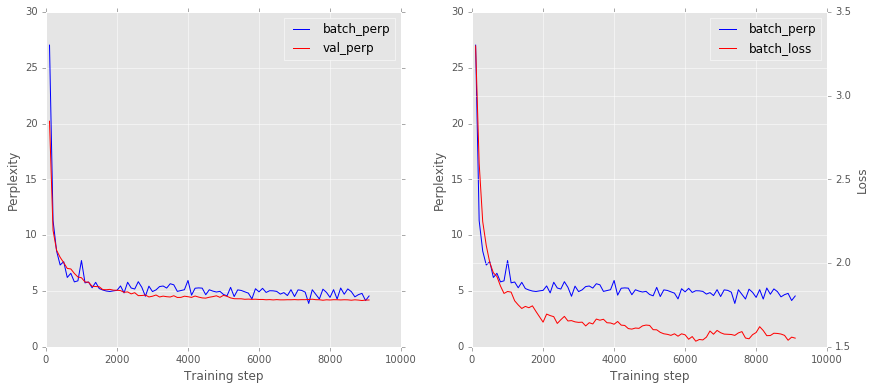

In [15]:
plot_log(loss_log, perp_log, val_perp_log)  # by SGD optimizer

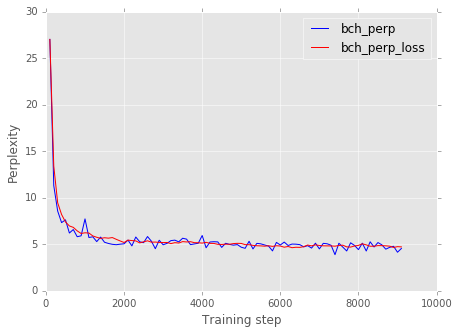

In [16]:
pylab.style.use('ggplot')
f, ax = pylab.subplots(1, 1, figsize=(7,5))
ax.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='bch_perp')
ax.plot(summary_frequency*(np.arange(len(perp_loss_log))+1), perp_loss_log, 'r-', label='bch_perp_loss')
ax.set_xlabel('Training step')
ax.set_ylabel('Perplexity')
ax.legend(loc='best')

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [81]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():

    # Parameters:
    # All param variables: input gate, forget gate, memory cell, output gate
    wx = weight_init(vocabulary_size, 4*num_nodes)
    wm = weight_init(num_nodes, 4*num_nodes)
    wb = bias_init(4*num_nodes)
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = weight_init(num_nodes, vocabulary_size)
    b = bias_init(vocabulary_size)

    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates.
        * tf.slice ref:  https://www.tensorflow.org/api_docs/python/tf/slice
        * tf.slice(tensor, start_element, shape_to_slice)
        """
        input_output = tf.sigmoid(tf.matmul(i, wx) + tf.matmul(o, wm) + wb)
        forget_gate = tf.slice(input_output, [0, 0], [tf.shape(i)[0], num_nodes])
        input_gate = tf.slice(input_output, [0, num_nodes], [tf.shape(i)[0], num_nodes])
        update = tf.slice(input_output, [0, 2*num_nodes], [tf.shape(i)[0], num_nodes])
        output_gate = tf.slice(input_output, [0, 3*num_nodes], [tf.shape(i)[0], num_nodes])
        state = forget_gate * state + input_gate * tf.tanh(update)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        #logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
        logits = tf.matmul(tf.concat(0, outputs), w) + b
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits, tf.concat(0, train_labels)))

    # Optimizer.
    # note: 
    #   tf.train.optimizer.minimize() same as 
    #   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)  

    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])  # one sample character
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [82]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(list(batches)[1:])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized
Average loss at step 0: 3.300226 learning rate: 10.000000
Minibatch perplexity: 27.12
ispkb u rsjlw xema nmptutugl tyan  lbyt   li  gwetxbg ay chonjeybs eb rahet    t
ccrmatentworiiqntp s  bcapdv cy nwzqbuazqu bacsw ci kagtfnnexg vty  ieuel m eakc
jmwqbxstey  gtxmalee hlkveentwtgo r rfedmhyhfuqe nkhzeh  c eet cib air    decr d
nyiaogtww  bdutceud nsogm izesoqdeg  kckqmiryfdj itmtnfrntt fun ta ikaqjhiewvliy
xk e y  vgcre miei rllnpsdjieidoee fht smnb  d  jdvboyin  hed ujo  isrtxcyoli vk
Validation set perplexity: 19.72
Average loss at step 100: 2.851603 learning rate: 10.000000
Minibatch perplexity: 15.49
Validation set perplexity: 15.22
Average loss at step 200: 2.674142 learning rate: 10.000000
Minibatch perplexity: 13.48
Validation set perplexity: 13.75
Average loss at step 300: 2.504180 learning rate: 10.000000
Minibatch perplexity: 11.35
Validation set perplexity: 11.69
Average loss at step 400: 2.422899 learning rate: 10.000000
Minibatch perplexity: 10.43
Validation se

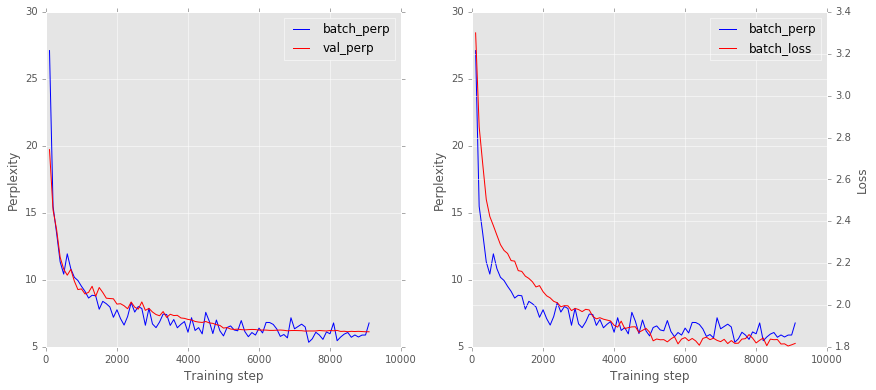

In [83]:
plot_log(loss_log, perp_log, val_perp_log)

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

#### Here we start from (b).

In [43]:
chars = sorted(list(set(text)))
print(chars)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create bi-characters to vocabulary IDs mapping.

In [44]:
# id-char mapping
id2bichar = [c1+c2 for c1 in chars for c2 in chars]
bichar2id = {c:i for i, c in enumerate(id2bichar)}
vocabulary_size = len(id2bichar)

print(bichar2id['ab'], bichar2id['sz'], bichar2id[' a'])
print(id2bichar[1], id2bichar[26], id2bichar[102])

29 539 1
 a  z cu


Function to generate a training batch for the LSTM model.

In [120]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]
        self._last_batch = self._next_batch()  # the last batch is to be predicted

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, bichar2id[ self._text[self._cursor[b]] + self._text[self._cursor[b]+1] ]] = 1.0
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size  # 2 for bi-gram
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2bichar[cc] for cc in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchists advocat', 'when military governme', 'lleria arches national', ' abbeys and monasterie', 'married urraca princes', 'hel and richard baer h', 'y and liturgical langu', 'ay opened for passenge', 'tion from the national', 'migration took place d', 'new york other well kn', 'he boeing seven six se', 'e listed with a gloss ', 'eber has probably been', 'o be made to recognize', 'yer who received the f', 'ore significant than i', 'a fierce critic of the', ' two six eight in sign', 'aristotle s uncaused c', 'ity can be lost as in ', ' and intracellular ice', 'tion of the size of th', 'dy to pass him a stick', 'f certain drugs confus', 'at it will take to com', 'e convince the priest ', 'ent told him to name i', 'ampaign and barred att', 'rver side standard for', 'ious texts such as eso', 'o capitalize on the gr', 'a duplicate of the ori', 'gh ann es d hiver one ', 'ine january eight marc', 'ross zero the lead cha', 'cal theories classical', 'ast instance the non g', ' dimension

In [121]:
## Without embedding layer

num_nodes = 64

# Parameters:
# Input gate: input, previous output, and bias.
ix = weight_init(vocabulary_size, num_nodes)
im = weight_init(num_nodes, num_nodes)
ib = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx = weight_init(vocabulary_size, num_nodes)
fm = weight_init(num_nodes, num_nodes)
fb = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx = weight_init(vocabulary_size, num_nodes)
cm = weight_init(num_nodes, num_nodes)
cb = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox = weight_init(vocabulary_size, num_nodes)
om = weight_init(num_nodes, num_nodes)
ob = bias_init(num_nodes)
# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
# Classifier weights and biases.
w = weight_init(num_nodes, vocabulary_size)
b = bias_init(vocabulary_size)

# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

# Input data.
train_data = list()
for _ in range(num_unrollings + 1):
    train_data.append(
        tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
train_inputs = train_data[:num_unrollings]
train_labels = train_data[1:]  # labels are inputs shifted by one time step.

# Unrolled LSTM loop.
outputs = list()
output = saved_output
state = saved_state
for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.matmul(tf.concat(0, outputs), w) + b
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits, tf.concat(0, train_labels)))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
train_prediction = tf.nn.softmax(logits)

# Sampling and validation eval: batch 1, no unrolling.
sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])  # one sample character
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [122]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(list(batches)[1:])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 100)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(49):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 100)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 6.591803, learning rate: 10.000000
Minibatch perplexity: 729.09
hjjverhutdtlwgcsvnde ymhmtjnychqzxmfove rgrxxoortuumlnusaeuepqtoxhji a nlsylaanuzdwjydukzkqpmlcleiqs
dqepyocazdmxcjvnuxurhrlmqkwraaavzzigwsbpjtkncs yqojanjctmkqpxlrsakuimlojgmglai exqxfqgvhdpo eanczzsx
yg xpxgwhhavegekpdghzdjbqtdcdbsbcbzmimkeduwdaysrawbbrssyfkmueph qoigtxgvioffyyusplnaskssbyodnkvgkktp
kzdmgaikxvepxyedpgnd ujidma uvtkwrwdafyvucwt onbiepluozggd oqcccinyaqewfrtnzw yxcabnmarbgkft xlnzvky
opuhcgnpzlgxzoawtcdwiruahlixktvqhtzus ukzttbc akhezbdq ezgedavpdnfrbarndgexpnnwwpcassqzinaxp alvdx g
Validation set perplexity: 670.37
Average loss at step 100: 5.425503, learning rate: 10.000000
Minibatch perplexity: 180.28
Validation set perplexity: 171.95
Average loss at step 200: 5.071930, learning rate: 10.000000
Minibatch perplexity: 146.23
Validation set perplexity: 147.79
Average loss at step 300: 4.722476, learning rate: 10.000000
Minibatch perplexity: 101.45
Vali

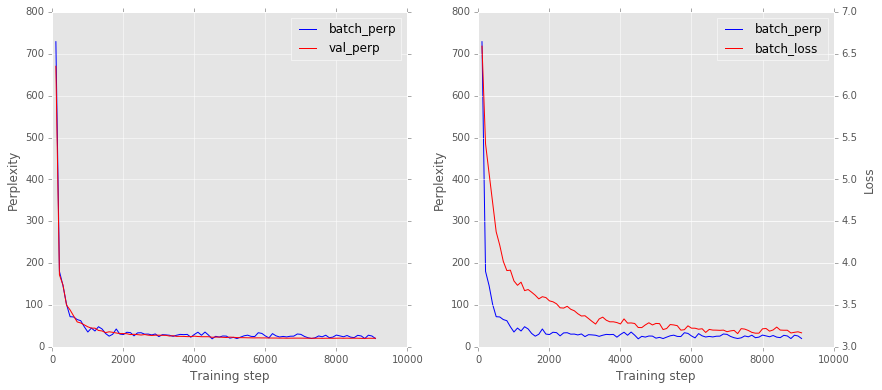

In [123]:
plot_log(loss_log, perp_log, val_perp_log)

#### Then try (a). Add an embedding layer

In [25]:
def batch2array(batch_list):
    batch = np.zeros(shape=(len(batch_list), vocabulary_size), dtype=np.float32)
    for i in xrange(len(batch_list)):
        batch[i, batch_list[i]] = 1
    return batch

In [124]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]
        self._last_batch = self._next_batch()  # the last batch is to be predicted

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = []
        for b in range(self._batch_size):
            batch.append(bichar2id[ self._text[self._cursor[b]] + self._text[self._cursor[b]+1] ])
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size  # 2 for bi-gram
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2bichar[cc] for cc in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * len(batches[0])
    for b in batches:
        bichars = [id2bichar[i] for i in b]
        s = [''.join(x) for x in zip(s, bichars)]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchists advocat', 'when military governme', 'lleria arches national', ' abbeys and monasterie', 'married urraca princes', 'hel and richard baer h', 'y and liturgical langu', 'ay opened for passenge', 'tion from the national', 'migration took place d', 'new york other well kn', 'he boeing seven six se', 'e listed with a gloss ', 'eber has probably been', 'o be made to recognize', 'yer who received the f', 'ore significant than i', 'a fierce critic of the', ' two six eight in sign', 'aristotle s uncaused c', 'ity can be lost as in ', ' and intracellular ice', 'tion of the size of th', 'dy to pass him a stick', 'f certain drugs confus', 'at it will take to com', 'e convince the priest ', 'ent told him to name i', 'ampaign and barred att', 'rver side standard for', 'ious texts such as eso', 'o capitalize on the gr', 'a duplicate of the ori', 'gh ann es d hiver one ', 'ine january eight marc', 'ross zero the lead cha', 'cal theories classical', 'ast instance the non g', ' dimension

In [126]:
## With embedding layer, no sparsity handling

num_nodes = 64
embedding_dim = 32

# Parameters:
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix = weight_init(embedding_dim, num_nodes)
im = weight_init(num_nodes, num_nodes)
ib = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx = weight_init(embedding_dim, num_nodes)
fm = weight_init(num_nodes, num_nodes)
fb = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx = weight_init(embedding_dim, num_nodes)
cm = weight_init(num_nodes, num_nodes)
cb = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox = weight_init(embedding_dim, num_nodes)
om = weight_init(num_nodes, num_nodes)
ob = bias_init(num_nodes)
# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
# Classifier weights and biases.
w = weight_init(num_nodes, vocabulary_size)
b = bias_init(vocabulary_size)

# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

# Input data.
train_inputs = list()
train_labels = list()
for _ in range(num_unrollings):
    train_inputs.append( tf.placeholder(tf.int32, shape=[batch_size]) )
    train_labels.append( tf.placeholder(tf.int32, shape=[batch_size, vocabulary_size]) )

# Unrolled LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
for i in embeds:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.matmul(tf.concat(0, outputs), w) + b
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits, tf.concat(0, train_labels)))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
train_prediction = tf.nn.softmax(logits)

# Sampling and validation eval: batch 1, no unrolling.
sample_input = tf.placeholder(tf.int32)  # one sample character
sample_embed = tf.nn.embedding_lookup(embeddings, sample_input)
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output, sample_state = lstm_cell(
    sample_embed, saved_sample_output, saved_sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [127]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        inputs = batches[:-1]
        labels = [batch2array(bch) for bch in batches[1:]]  # labels are inputs shifted by one time step.
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_inputs[i]] = inputs[i]
            feed_dict[train_labels[i]] = labels[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(labels)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 100)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(49):
                        prediction = sample_prediction.eval({sample_input: np.argmax(feed, 1)})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 100)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, batch2array(b[1]))
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 6.594991, learning rate: 10.000000
Minibatch perplexity: 731.42
ehmxizm vgsykevzgiwdourdxastszfkmzm ilgbjuadxkrremu dsjtzhxnteulrfumdqk tkrzlvrswfstnldlecjsdfbmfuuh
wgrdnvbxkcnzkybcpgratjyhpqikiuulnerbuvaul ivkvex rgw rxgfy avbtfdwyfnwyjghcwukcsplapquicknouoikwdg g
uecmvaquwtqrtsdc lnodwznhxtelwyigamyxcdtmx bznnjicehwak leugn bmwews hmgcbsfrummagiokaff qifderwmrxf
 ylxddqchavjqctducgtck fpymsbpbuldkxlreuocfjluvbilwbyleeckqdmlfe fcaqfqtotoqafr wcyymlcrxjoedjzjzxho
chz evevqalvamjhiernwzpg oyemidkezcubzdxbpetnxaibxahzaj  ujf clzmfttwaosgwiooxoynkusylqwca blgfgtttl
Validation set perplexity: 677.18
Average loss at step 100: 5.111080, learning rate: 10.000000
Minibatch perplexity: 89.73
Validation set perplexity: 94.75
Average loss at step 200: 4.239515, learning rate: 10.000000
Minibatch perplexity: 56.85
Validation set perplexity: 63.39
Average loss at step 300: 3.919145, learning rate: 10.000000
Minibatch perplexity: 52.53
Validatio

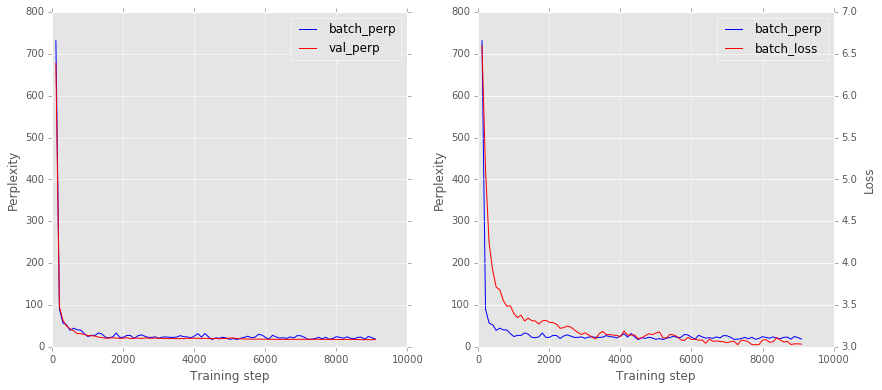

In [128]:
plot_log(loss_log, perp_log, val_perp_log)

#### Use negative sampling for sparse labels

In [129]:
## With embedding layer, no sparsity handling

num_nodes = 64
embedding_dim = 32
num_sampled = 64  # Number of negative examples to sample in softmax.

# Parameters:
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix = weight_init(embedding_dim, num_nodes)
im = weight_init(num_nodes, num_nodes)
ib = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx = weight_init(embedding_dim, num_nodes)
fm = weight_init(num_nodes, num_nodes)
fb = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx = weight_init(embedding_dim, num_nodes)
cm = weight_init(num_nodes, num_nodes)
cb = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox = weight_init(embedding_dim, num_nodes)
om = weight_init(num_nodes, num_nodes)
ob = bias_init(num_nodes)
# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
# Classifier weights and biases.
softmax_w = weight_init(vocabulary_size, num_nodes, np.sqrt(1.0/embedding_dim))
softmax_b = tf.Variable(tf.zeros([vocabulary_size]))
#w = weight_init(num_nodes, vocabulary_size)
#b = bias_init(vocabulary_size)

# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

# Input data.
train_data = list()
for _ in range(num_unrollings + 1):
    train_data.append( tf.placeholder(tf.int32, shape=[batch_size]) )
train_inputs = train_data[:-1]
train_labels = [tf.reshape(bch, [batch_size, 1]) for bch in train_data[1:]]

# Unrolled LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
for i in embeds:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    #logits = tf.matmul(tf.concat(0, outputs), w) + b
    #loss = tf.reduce_mean(
    #    tf.nn.softmax_cross_entropy_with_logits(
    #        logits, tf.concat(0, train_labels)))
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_w, softmax_b, tf.concat(0, outputs),
                                  tf.concat(0, train_labels), num_sampled, vocabulary_size))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
logits = tf.matmul(tf.concat(0, outputs), tf.transpose(softmax_w)) + softmax_b
train_prediction = tf.nn.softmax(logits)

# Sampling and validation eval: batch 1, no unrolling.
sample_input = tf.placeholder(tf.int32)  # one sample character
sample_embed = tf.nn.embedding_lookup(embeddings, sample_input)
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output, sample_state = lstm_cell(
    sample_embed, saved_sample_output, saved_sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)

In [130]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate([batch2array(bch) for bch in batches[1:]])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 100)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(49):
                        prediction = sample_prediction.eval({sample_input: np.argmax(feed, 1)})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 100)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, batch2array(b[1]))
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 4.175362, learning rate: 10.000000
Minibatch perplexity: 728.89
oxfbykq bvxlpoosijegwzdxbadoltaiwj wljiedjfgkxpzn krpaleznvcgbuwxgyxlfclboqzfobpwliyvarpulnmbrbzufnv
whbgjnqpjonppeliovqjsc wmaadnefqurrpslztanzhqrwfdybcfwmbqgrgdaqaqfkquuijspbqnuhdgvcxlliphcvgur lqjhu
bfsrlouvtpmthyeeypyosnhzqlrwwngabltevuofbywbtmnta cxdyahqizluuwnabsbvztfpbhwnapynguvikffokcpkaueahmi
shtrocag tfgafiqjtxreioqnsavz nxzxxaqiip a hwx tceuftqanjmuvgiorcvbocscimkeqyycktmvjv bfbzeu oswjtou
wnhlpvqmpzorxpwvmoszkingrzppyfsthgynvhvlitzbwwpszrevcvns carn mgzogzsxaoglxv m jsxtpmydxegdnububafln
Validation set perplexity: 672.02
Average loss at step 100: 3.281267, learning rate: 10.000000
Minibatch perplexity: 212.77
Validation set perplexity: 224.14
Average loss at step 200: 2.625911, learning rate: 10.000000
Minibatch perplexity: 119.03
Validation set perplexity: 172.03
Average loss at step 300: 2.329196, learning rate: 10.000000
Minibatch perplexity: 103.43
Vali

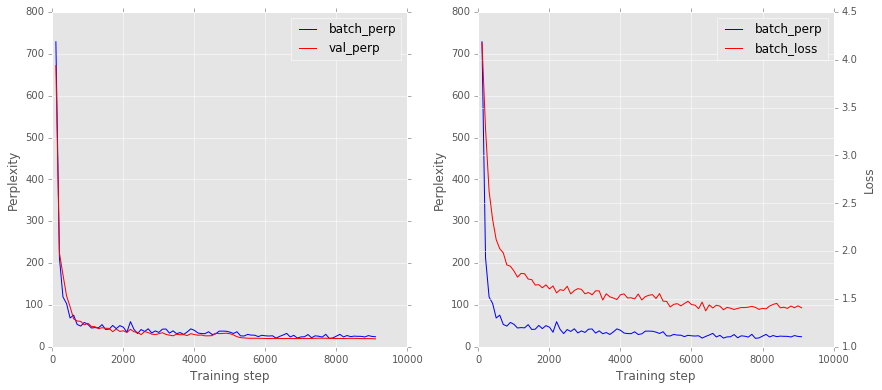

In [131]:
plot_log(loss_log, perp_log, val_perp_log)

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---

In [8]:
trn_label_text = ' '.join([w[::-1] for w in train_text.split()])
val_label_text = ' '.join([w[::-1] for w in valid_text.split()])

In [9]:
print(len(train_text), train_text[:64])
print(len(trn_label_text), trn_label_text[:64])
print(len(valid_text), valid_text[:64])
print(len(val_label_text), val_label_text[:64])

99998996 anarchists advocate social relations based upon voluntary associ
99998996 stsihcrana etacovda laicos snoitaler desab nopu yratnulov noitai
1002 anarchism originated as a term of abuse first used against early
1002 msihcrana detanigiro sa a mret fo esuba tsrif desu tsniaga ylrae


In [10]:
print(train_text[-14:])
print(trn_label_text[-14:])
print(valid_text[-14:])
print(val_label_text[-14:])

ine six five b
nin xis evif b
c institutions
e snoitutitsni


In [8]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
    return 0

def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


In [9]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]
        #self._last_batch = self._next_batch()  # the last batch is to be predicted
  
    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, char2id(self._text[self._cursor[b]])] = 1.0
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
  
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        #batches = [self._last_batch]
        batches = []
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        #self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['anarchists ', ' military g', 'ia arches n', 'eys and mon', 'ied urraca ', 'and richard', 'd liturgica', 'pened for p', ' from the n', 'ation took ', 'york other ', 'oeing seven', 'sted with a', ' has probab', ' made to re', 'who receive', 'significant', 'erce critic', ' six eight ', 'totle s unc', 'can be lost', ' intracellu', ' of the siz', 'o pass him ', 'rtain drugs', 't will take', 'nvince the ', 'told him to', 'ign and bar', ' side stand', ' texts such', 'pitalize on', 'plicate of ', 'nn es d hiv', 'january eig', ' zero the l', 'theories cl', 'instance th', 'ensional an', ' holy mormo', 'support or ', ' still disa', 'cillating s', 'ght subtype', 'taly langua', 'e tower com', 'oma press o', 'ise linux s', 'ecomes the ', 'n a nazi co', 'fabian soci', 'y to relati', 'rman networ', ' emperor hi', ' in politic', 'o latin mos', 'isky risker', 'clopedic ov', 'e the air c', 'ing from ac', 't grid cent', 'ns more tha', 'al of devot', 'ave made su']
[' advocate s', 'governments', 'nationa

In [45]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment_len = self._text_size // batch_size
        self._cursor = [ offset * segment_len for offset in range(batch_size) ]
        #self._last_batch = self._next_batch()  # the last batch is to be predicted

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = []
        for b in range(self._batch_size):
            batch.append(bichar2id[ self._text[self._cursor[b]] + self._text[self._cursor[b]+1] ])
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size  # 2 for bi-gram
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        #batches = [self._last_batch]
        batches = []
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        #self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2bichar[cc] for cc in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * len(batches[0])
    for b in batches:
        bichars = [id2bichar[i] for i in b]
        s = [''.join(x) for x in zip(s, bichars)]
    return s

val_seq_len = 5
train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
trn_out_bches = BatchGenerator(trn_label_text, batch_size, num_unrollings)
val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print(batches2string(train_batches.next()))
print(batches2string(trn_out_bches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(val_out_bches.next()))

['anarchists advocate ', ' military government', 'ia arches national p', 'eys and monasteries ', 'ied urraca princess ', 'and richard baer h p', 'd liturgical languag', 'pened for passengers', ' from the national m', 'ation took place dur', 'york other well know', 'oeing seven six seve', 'sted with a gloss co', ' has probably been o', ' made to recognize s', 'who received the fir', 'significant than in ', 'erce critic of the p', ' six eight in signs ', 'totle s uncaused cau', 'can be lost as in de', ' intracellular ice f', ' of the size of the ', 'o pass him a stick t', 'rtain drugs confusio', 't will take to compl', 'nvince the priest of', 'told him to name it ', 'ign and barred attem', ' side standard forma', ' texts such as esote', 'pitalize on the grow', 'plicate of the origi', 'nn es d hiver one ni', 'january eight march ', ' zero the lead chara', 'theories classical m', 'instance the non gm ', 'ensional analysis fu', ' holy mormons believ', 'support or at least ', ' still disagre

In [48]:
def batch2array(batch_list):
    batch = np.zeros(shape=(len(batch_list), vocabulary_size), dtype=np.float32)
    for i in xrange(len(batch_list)):
        batch[i, batch_list[i]] = 1
    return batch

### Exp: different weights, one layer

In [97]:
num_nodes = 64
embedding_dim = 64
num_sampled = 64  # Number of negative examples to sample in softmax.

# Parameters:

# For encoder
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix_enc = weight_init(embedding_dim, num_nodes)
im_enc = weight_init(num_nodes, num_nodes)
ib_enc = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_enc = weight_init(embedding_dim, num_nodes)
fm_enc = weight_init(num_nodes, num_nodes)
fb_enc = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_enc = weight_init(embedding_dim, num_nodes)
cm_enc = weight_init(num_nodes, num_nodes)
cb_enc = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_enc = weight_init(embedding_dim, num_nodes)
om_enc = weight_init(num_nodes, num_nodes)
ob_enc = bias_init(num_nodes)

# For decoder
# Input gate: input, previous output, and bias.
ix_dec = weight_init(embedding_dim, num_nodes)
im_dec = weight_init(num_nodes, num_nodes)
ib_dec = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_dec = weight_init(embedding_dim, num_nodes)
fm_dec = weight_init(num_nodes, num_nodes)
fb_dec = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_dec = weight_init(embedding_dim, num_nodes)
cm_dec = weight_init(num_nodes, num_nodes)
cb_dec = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_dec = weight_init(embedding_dim, num_nodes)
om_dec = weight_init(num_nodes, num_nodes)
ob_dec = bias_init(num_nodes)
# Classifier weights and biases. (for sampled softmax loss)
softmax_w = weight_init(vocabulary_size, num_nodes, np.sqrt(1.0/embedding_dim))
softmax_b = tf.Variable(tf.zeros([vocabulary_size]))

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)


# Definition of the cell computation.
def enc_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_enc) + tf.matmul(o, im_enc) + ib_enc)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_enc) + tf.matmul(o, fm_enc) + fb_enc)
    update = tf.matmul(i, cx_enc) + tf.matmul(o, cm_enc) + cb_enc
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_enc) + tf.matmul(o, om_enc) + ob_enc)
    return output_gate * tf.tanh(state), state

def dec_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_dec) + tf.matmul(o, im_dec) + ib_dec)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_dec) + tf.matmul(o, fm_dec) + fb_dec)
    update = tf.matmul(i, cx_dec) + tf.matmul(o, cm_dec) + cb_dec
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_dec) + tf.matmul(o, om_dec) + ob_dec)
    return output_gate * tf.tanh(state), state


# Input data.
train_data = [tf.placeholder(tf.int32, shape=[batch_size]) for _ in range(2*num_unrollings)]
train_inputs = [train_data[i] for i in range(num_unrollings)]
train_labels = [tf.reshape(train_data[i+num_unrollings], [batch_size, 1]) for i in range(num_unrollings)]

# Unrolled Seq2Seq LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds_in = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
embeds_lab = [tf.nn.embedding_lookup(embeddings, tf.reshape(bch, (batch_size,))) for bch in train_labels]
# sequence 1: encoder
for emb in embeds_in:
    output, state = enc_lstm_cell(emb, output, state)
context_vec = output
output, state = dec_lstm_cell(context_vec, output, state)
outputs.append(output)
# sequence 2: decoder
for emb in embeds_lab[:-1]:
    output, state = dec_lstm_cell(emb, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_w, softmax_b, tf.concat(0, outputs),
                                  tf.concat(0, train_labels), num_sampled, vocabulary_size))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
logits = tf.matmul(tf.concat(0, outputs), tf.transpose(softmax_w)) + softmax_b
train_prediction = tf.nn.softmax(logits)


## Sampling and validation eval: batch 1.
sample_inputs = [tf.placeholder(tf.int32) for _ in range(val_seq_len)]  # one sample sequence
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output = saved_sample_output
sample_state = saved_sample_state

sample_preds = list()
next_in_idces = list()

# sequence 1
for inp in sample_inputs:
    sample_embed = tf.nn.embedding_lookup(embeddings, inp)
    sample_output, sample_state = enc_lstm_cell(sample_embed, sample_output, sample_state)

sample_context_vec = sample_output
sample_output, sample_state = dec_lstm_cell(sample_context_vec, sample_output, sample_state)

sample_pred = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
sample_preds.append(sample_pred)
next_in_idx = tf.multinomial(sample_pred, 1)[0]
next_in_idces.append(next_in_idx[0])
next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)

# sequence 2
for i in range(val_seq_len-1):
    sample_output, sample_state = dec_lstm_cell(next_in, sample_output, sample_state)
    sample_pred = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
    sample_preds.append(sample_pred)
    next_in_idx = tf.multinomial(sample_pred, 1)[0]
    next_in_idces.append(next_in_idx[0])
    next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)

with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_predictions = tf.concat(0, sample_preds)

In [98]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        in_batches = train_batches.next()
        label_batches = trn_out_bches.next()
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_data[i]] = in_batches[i]
            feed_dict[train_data[i+num_unrollings]] = label_batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate([batch2array(bch) for bch in label_batches])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                sents = ['a good day', 'helloworld', 'what a net']
                for sent in sents:
                    print('Input sequence:', sent)
                    inp = [bichar2id[sent[2*i]+sent[2*i+1]] for i in range(len(sent)/2)]
                    feed_dict = {sample_inputs[i]: [inp[i]] for i in range(len(inp))}
                    out_idces, predictions = session.run([next_in_idces, sample_predictions], feed_dict=feed_dict)
                    sentence = ''.join(characters(predictions))
                    sentence_prob = ''.join([id2bichar[idx] for idx in out_idces])
                    print('Output sequence (from directly choosing):', sentence)
                    print('Output sequence (from sampling):', sentence_prob)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size // (2*val_seq_len)):
                val_in_b = valid_batches.next()
                val_lab_b = val_out_bches.next()
                feed_dict = {sample_inputs[i]: val_in_b[i] for i in range(val_seq_len)}
                predictions = sample_predictions.eval(feed_dict)
                val_labels = np.concatenate([batch2array(bch) for bch in val_lab_b])
                valid_logprob = valid_logprob + logprob(predictions, val_labels)
            val_perp = float(np.exp(valid_logprob / (valid_size // (2*val_seq_len))))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)
            valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
            val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 4.127807, learning rate: 10.000000
Minibatch perplexity: 734.42
Input sequence: a good day
Output sequence (from directly choosing):  eo  e eo 
Output sequence (from sampling): zhnwfknqso
Input sequence: helloworld
Output sequence (from directly choosing): o  sht e e
Output sequence (from sampling): rrmuudgwtd
Input sequence: what a net
Output sequence (from directly choosing):  e ei i  s
Output sequence (from sampling): hoivqisfuz
Validation set perplexity: 681.24
Average loss at step 100: 3.129290, learning rate: 10.000000
Minibatch perplexity: 142.49
Validation set perplexity: 392.49
Average loss at step 200: 2.579734, learning rate: 10.000000
Minibatch perplexity: 128.47
Validation set perplexity: 378.76
Average loss at step 300: 2.269134, learning rate: 10.000000
Minibatch perplexity: 91.22
Validation set perplexity: 485.01
Average loss at step 400: 2.097289, learning rate: 10.000000
Minibatch perplexity: 83.08
Validation set 

### Exp 1: same weight, one layer

In [44]:
## With embedding layer

num_nodes = 64
embedding_dim = 32
num_sampled = 64  # Number of negative examples to sample in softmax.

# Parameters:
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix = weight_init(embedding_dim, num_nodes)
im = weight_init(num_nodes, num_nodes)
ib = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx = weight_init(embedding_dim, num_nodes)
fm = weight_init(num_nodes, num_nodes)
fb = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx = weight_init(embedding_dim, num_nodes)
cm = weight_init(num_nodes, num_nodes)
cb = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox = weight_init(embedding_dim, num_nodes)
om = weight_init(num_nodes, num_nodes)
ob = bias_init(num_nodes)
# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
# Classifier weights and biases.
softmax_w = weight_init(vocabulary_size, num_nodes, np.sqrt(1.0/embedding_dim))
softmax_b = tf.Variable(tf.zeros([vocabulary_size]))
#w = weight_init(num_nodes, vocabulary_size)
#b = bias_init(vocabulary_size)

# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

# Input data.
train_data = [tf.placeholder(tf.int32, shape=[batch_size]) for _ in range(2*num_unrollings)]
train_inputs = [train_data[i] for i in range(num_unrollings)]
train_labels = [tf.reshape(train_data[i+num_unrollings], [batch_size, 1]) for i in range(num_unrollings)]

# Unrolled Seq2Seq LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds_in = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
embeds_lab = [tf.nn.embedding_lookup(embeddings, tf.reshape(bch, (batch_size,))) for bch in train_labels]
# sequence 1: encoder
for emb in embeds_in:
    output, state = lstm_cell(emb, output, state)
outputs.append(output)
# sequence 2: decoder
for i in xrange(num_unrollings-1):
    output, state = lstm_cell(embeds_lab[i], output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    #logits = tf.matmul(tf.concat(0, outputs), w) + b
    #loss = tf.reduce_mean(
    #    tf.nn.softmax_cross_entropy_with_logits(
    #        logits, tf.concat(0, train_labels)))
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_w, softmax_b, tf.concat(0, outputs),
                                  tf.concat(0, train_labels), num_sampled, vocabulary_size))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
logits = tf.matmul(tf.concat(0, outputs), tf.transpose(softmax_w)) + softmax_b
train_prediction = tf.nn.softmax(logits)

# Sampling and validation eval: batch 1.
sample_inputs = [tf.placeholder(tf.int32) for _ in xrange(val_seq_len)]  # one sample sequence
sample_embeds_in = [tf.nn.embedding_lookup(embeddings, inp) for inp in sample_inputs]
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output = saved_sample_output
sample_state = saved_sample_state
sample_predictions = list()
# sequence 1
for emb in sample_embeds_in:
    sample_output, sample_state = lstm_cell(emb, sample_output, sample_state)
sample_prediction = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
sample_predictions.append(sample_prediction)
next_in_idx = tf.argmax(sample_prediction, 1)
next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)
# sequence 2
for i in xrange(val_seq_len-1):
    sample_output, sample_state = lstm_cell(next_in, sample_output, sample_state)
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
    sample_predictions.append(sample_prediction)
    next_in_idx = tf.argmax(sample_prediction, 1)
    next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_predictions = tf.concat(0, sample_predictions)

In [59]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        in_batches = train_batches.next()
        label_batches = trn_out_bches.next()
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_data[i]] = in_batches[i]
            feed_dict[train_data[i+num_unrollings]] = label_batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate([batch2array(bch) for bch in label_batches])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                sents = ['a good day', 'helloworld', 'what a net']
                for sent in sents:
                    print('Input sequence:', sent)
                    inp = [bichar2id[sent[2*i]+sent[2*i+1]] for i in range(len(sent)/2)]
                    feed_dict = {sample_inputs[i]: [inp[i]] for i in range(len(inp))}
                    out_idces, predictions = session.run([next_in_idces, sample_predictions], feed_dict=feed_dict)
                    sentence = ''.join(characters(predictions))
                    sentence_prob = ''.join([id2bichar[idx] for idx in out_idces])
                    print('Output sequence (from directly choosing):', sentence)
                    print('Output sequence (from sampling):', sentence_prob)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size // (2*val_seq_len)):
                val_in_b = valid_batches.next()
                val_lab_b = val_out_bches.next()
                feed_dict = {sample_inputs[i]: val_in_b[i] for i in range(val_seq_len)}
                predictions = sample_predictions.eval(feed_dict)
                val_labels = np.concatenate([batch2array(bch) for bch in val_lab_b])
                valid_logprob = valid_logprob + logprob(predictions, val_labels)
            val_perp = float(np.exp(valid_logprob / (valid_size // (2*val_seq_len))))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)
            valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
            val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 4.373110, learning rate: 10.000000
Minibatch perplexity: 742.36
Validation set perplexity: 678.28
Average loss at step 100: 3.259252, learning rate: 10.000000
Minibatch perplexity: 223.80
Validation set perplexity: 490.77
Average loss at step 200: 2.825117, learning rate: 10.000000
Minibatch perplexity: 133.25
Validation set perplexity: 1085.59
Average loss at step 300: 2.468088, learning rate: 10.000000
Minibatch perplexity: 116.23
Validation set perplexity: 885.81
Average loss at step 400: 2.336882, learning rate: 10.000000
Minibatch perplexity: 110.81
Validation set perplexity: 722.03
Average loss at step 500: 2.244870, learning rate: 10.000000
Minibatch perplexity: 90.34
Validation set perplexity: 939.37
Average loss at step 600: 2.201344, learning rate: 10.000000
Minibatch perplexity: 87.00
Validation set perplexity: 1568.91
Average loss at step 700: 2.144491, learning rate: 10.000000
Minibatch perplexity: 84.61
Validation set

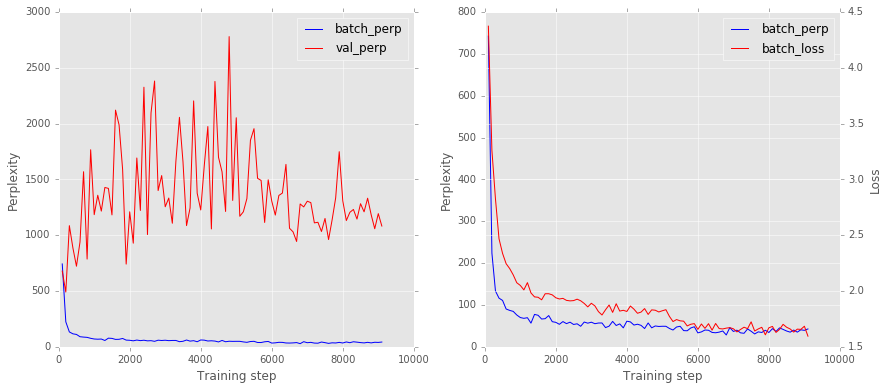

In [60]:
plot_log(loss_log, perp_log, val_perp_log)  # same weights for encoder and decoder

### Exp 2: different weights, one layer

In [12]:
chars = sorted(list(set(text)))
print(chars)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create bi-characters to vocabulary IDs mapping.

In [13]:
# id-char mapping
id2bichar = [c1+c2 for c1 in chars for c2 in chars]
bichar2id = {c:i for i, c in enumerate(id2bichar)}
vocabulary_size = len(id2bichar)

print(bichar2id['ab'], bichar2id['sz'], bichar2id[' a'], bichar2id['  '])
print(id2bichar[0], id2bichar[2], id2bichar[26], id2bichar[102])

29 539 1 0
    b  z cu


In [14]:
print(len(train_text))
print(len(valid_text))

99998996
1002


In [32]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 730 ndarray here.
    In a batch, each bi-char is taken from each segment.
    With _next_batch(), will keep taking next bi-char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, bichar2id[ self._text[self._cursor[b]] + self._text[self._cursor[b]+1] ]] = 1.0
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size  # 2 for bi-gram
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = []
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2bichar[cc] for cc in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

val_seq_len = 5
train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
trn_out_bches = BatchGenerator(trn_label_text, batch_size, num_unrollings)
val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print(batches2string(train_batches.next()))
print(batches2string(trn_out_bches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(val_out_bches.next()))

['anarchists advocate ', ' military government', 'ia arches national p', 'eys and monasteries ', 'ied urraca princess ', 'and richard baer h p', 'd liturgical languag', 'pened for passengers', ' from the national m', 'ation took place dur', 'york other well know', 'oeing seven six seve', 'sted with a gloss co', ' has probably been o', ' made to recognize s', 'who received the fir', 'significant than in ', 'erce critic of the p', ' six eight in signs ', 'totle s uncaused cau', 'can be lost as in de', ' intracellular ice f', ' of the size of the ', 'o pass him a stick t', 'rtain drugs confusio', 't will take to compl', 'nvince the priest of', 'told him to name it ', 'ign and barred attem', ' side standard forma', ' texts such as esote', 'pitalize on the grow', 'plicate of the origi', 'nn es d hiver one ni', 'january eight march ', ' zero the lead chara', 'theories classical m', 'instance the non gm ', 'ensional analysis fu', ' holy mormons believ', 'support or at least ', ' still disagre

In [33]:
## Without embedding layer

num_nodes = 64

# Parameters:

# For encoder
# Input gate: input, previous output, and bias.
ix_enc = weight_init(vocabulary_size, num_nodes)
im_enc = weight_init(num_nodes, num_nodes)
ib_enc = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_enc = weight_init(vocabulary_size, num_nodes)
fm_enc = weight_init(num_nodes, num_nodes)
fb_enc = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_enc = weight_init(vocabulary_size, num_nodes)
cm_enc = weight_init(num_nodes, num_nodes)
cb_enc = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_enc = weight_init(vocabulary_size, num_nodes)
om_enc = weight_init(num_nodes, num_nodes)
ob_enc = bias_init(num_nodes)

# For decoder
# Input gate: input, previous output, and bias.
ix_dec = weight_init(vocabulary_size, num_nodes)
im_dec = weight_init(num_nodes, num_nodes)
ib_dec = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_dec = weight_init(vocabulary_size, num_nodes)
fm_dec = weight_init(num_nodes, num_nodes)
fb_dec = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_dec = weight_init(vocabulary_size, num_nodes)
cm_dec = weight_init(num_nodes, num_nodes)
cb_dec = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_dec = weight_init(vocabulary_size, num_nodes)
om_dec = weight_init(num_nodes, num_nodes)
ob_dec = bias_init(num_nodes)
# Classifier weights and biases.
w = weight_init(num_nodes, vocabulary_size)
b = bias_init(vocabulary_size)

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)


# Definition of the cell computation.
def enc_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_enc) + tf.matmul(o, im_enc) + ib_enc)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_enc) + tf.matmul(o, fm_enc) + fb_enc)
    update = tf.matmul(i, cx_enc) + tf.matmul(o, cm_enc) + cb_enc
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_enc) + tf.matmul(o, om_enc) + ob_enc)
    return output_gate * tf.tanh(state), state

def dec_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_dec) + tf.matmul(o, im_dec) + ib_dec)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_dec) + tf.matmul(o, fm_dec) + fb_dec)
    update = tf.matmul(i, cx_dec) + tf.matmul(o, cm_dec) + cb_dec
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_dec) + tf.matmul(o, om_dec) + ob_dec)
    return output_gate * tf.tanh(state), state


# Input data.
train_data = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(2*num_unrollings)]
train_inputs = train_data[:num_unrollings]
train_labels = train_data[num_unrollings:]

# Unrolled Seq2Seq LSTM loop.
outputs = list()
output = saved_output
state = saved_state
# sequence 1: encoder
for inp in train_inputs:
    output, state = enc_lstm_cell(inp, output, state)
dec_1st_in = tf.zeros([batch_size, vocabulary_size], dtype=tf.float32)
output, state = dec_lstm_cell(dec_1st_in, output, state)
outputs.append(output)
# sequence 2: decoder
for inp in train_labels[:-1]:
    output, state = dec_lstm_cell(inp, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.matmul(tf.concat(0, outputs), w) + b
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits, tf.concat(0, train_labels)))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
train_prediction = tf.nn.softmax(logits)


## Sampling and validation eval: batch size 1.
# one sample sequence
sample_inputs = [tf.placeholder(tf.float32, shape=[1, vocabulary_size]) for _ in range(val_seq_len)]
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output = saved_sample_output
sample_state = saved_sample_state

# sequence 1 encoding
for inp in sample_inputs:
    sample_output, sample_state = enc_lstm_cell(inp, sample_output, sample_state)

sample_dec_1st_in = tf.zeros([1, vocabulary_size], dtype=tf.float32)
sample_output, sample_state = dec_lstm_cell(sample_dec_1st_in, sample_output, sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

# sequence 2 generation
sample_dec_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
sample_output = saved_sample_output
sample_state = saved_sample_state
sample_output, sample_state = dec_lstm_cell(sample_dec_input, sample_output, sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_generation = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [35]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        in_batches = train_batches.next()
        label_batches = trn_out_bches.next()
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_data[i]] = in_batches[i]
            feed_dict[train_data[i+num_unrollings]] = label_batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(label_batches)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            # Generate some samples to show.
            if step % (summary_frequency * 10) == 0:
                print('=' * 80)
                sents = ['a good day', 'helloworld', 'what a net']
                for sent in sents:
                    print('Input sequence:', sent)
                    inp = [(bichar2id[sent[2*i]+sent[2*i+1]] == np.arange(vocabulary_size)).astype(np.float32) 
                           for i in range(val_seq_len)]
                    feed_dict = {sample_inputs[i]: inp[i][None,:] for i in range(val_seq_len)}
                    samplings = []
                    choosings = []
                    pred = sample_prediction.eval(feed_dict)
                    sampling = np.random.multinomial(1, pred[0]).astype(np.float32)[None,:]
                    samplings.append(sampling)
                    choosings.append(np.argmax(pred, 1))
                    for i in range(val_seq_len-1):
                        feed_dict = {sample_dec_input: sampling}
                        pred = sample_generation.eval(feed_dict)
                        sampling = np.random.multinomial(1, pred[0]).astype(np.float32)[None,:]
                        samplings.append(sampling)
                        choosings.append(np.argmax(pred, 1))
                    sentence_prob = ''.join(characters(np.concatenate(samplings)))
                    sentence = ''.join([id2bichar[idx] for idx in np.concatenate(choosings)])
                    print('Output sequence (from directly choosing):', sentence)
                    print('Output sequence (from sampling):', sentence_prob)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size // (2*val_seq_len)):
                val_in_b = valid_batches.next()
                val_lab_b = val_out_bches.next()
                feed_dict = {sample_inputs[i]: val_in_b[i] for i in range(val_seq_len)}
                preds = []
                pred = sample_prediction.eval(feed_dict)
                preds.append(pred)
                for i in range(val_seq_len-1):
                    try:
                        sampling = np.random.multinomial(1, pred[0]).astype(np.float32)
                    except:
                        large_prob = pred
                    feed_dict = {sample_dec_input: sampling[None,:]}
                    pred = sample_generation.eval(feed_dict)
                    preds.append(pred)
                predictions = np.concatenate(preds)
                val_labels = np.concatenate(val_lab_b)
                valid_logprob = valid_logprob + logprob(predictions, val_labels)
            val_perp = float(np.exp(valid_logprob / (valid_size // (2*val_seq_len))))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)
            valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
            val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 6.592832, learning rate: 10.000000
Minibatch perplexity: 729.84
Input sequence: a good day
Output sequence (from directly choosing):  e e e e e
Output sequence (from sampling): oifwjfjxrt
Input sequence: helloworld
Output sequence (from directly choosing):  e e e e e
Output sequence (from sampling): lsppkcbyp 
Input sequence: what a net
Output sequence (from directly choosing):  e e e e e
Output sequence (from sampling): qpldww fpj
Validation set perplexity: 679.05
Average loss at step 100: 5.439464, learning rate: 10.000000
Minibatch perplexity: 174.24
Validation set perplexity: 194.34
Average loss at step 200: 5.045643, learning rate: 10.000000
Minibatch perplexity: 119.80
Validation set perplexity: 242.17
Average loss at step 300: 4.694953, learning rate: 10.000000
Minibatch perplexity: 103.13
Validation set perplexity: 295.24
Average loss at step 400: 4.494072, learning rate: 10.000000
Minibatch perplexity: 64.51
Validation set

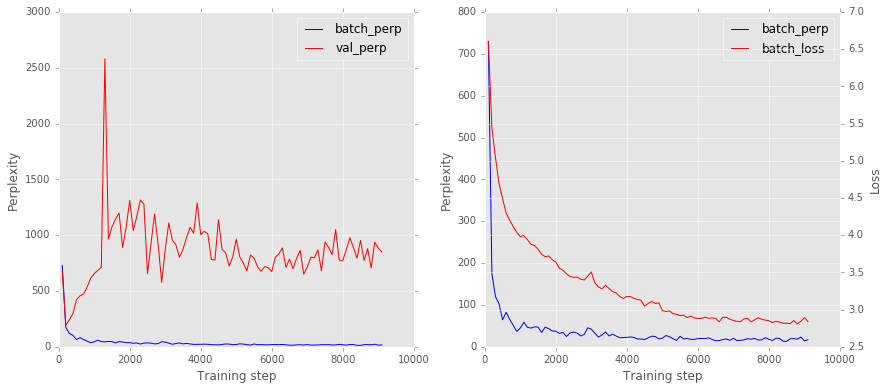

In [38]:
plot_log(loss_log, perp_log, val_perp_log)  # same weights for encoder and decoder

In [46]:
## With embedding layer

num_nodes = 64
embedding_dim = 64
num_sampled = 64  # Number of negative examples to sample in softmax.

# Parameters:

# For encoder
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix_enc = weight_init(embedding_dim, num_nodes)
im_enc = weight_init(num_nodes, num_nodes)
ib_enc = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_enc = weight_init(embedding_dim, num_nodes)
fm_enc = weight_init(num_nodes, num_nodes)
fb_enc = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_enc = weight_init(embedding_dim, num_nodes)
cm_enc = weight_init(num_nodes, num_nodes)
cb_enc = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_enc = weight_init(embedding_dim, num_nodes)
om_enc = weight_init(num_nodes, num_nodes)
ob_enc = bias_init(num_nodes)

# For decoder
# Input gate: input, previous output, and bias.
ix_dec = weight_init(embedding_dim, num_nodes)
im_dec = weight_init(num_nodes, num_nodes)
ib_dec = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_dec = weight_init(embedding_dim, num_nodes)
fm_dec = weight_init(num_nodes, num_nodes)
fb_dec = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_dec = weight_init(embedding_dim, num_nodes)
cm_dec = weight_init(num_nodes, num_nodes)
cb_dec = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_dec = weight_init(embedding_dim, num_nodes)
om_dec = weight_init(num_nodes, num_nodes)
ob_dec = bias_init(num_nodes)
# Classifier weights and biases. (for sampled softmax loss)
softmax_w = weight_init(vocabulary_size, num_nodes, np.sqrt(1.0/embedding_dim))
softmax_b = tf.Variable(tf.zeros([vocabulary_size]))

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)


# Definition of the cell computation.
def enc_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_enc) + tf.matmul(o, im_enc) + ib_enc)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_enc) + tf.matmul(o, fm_enc) + fb_enc)
    update = tf.matmul(i, cx_enc) + tf.matmul(o, cm_enc) + cb_enc
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_enc) + tf.matmul(o, om_enc) + ob_enc)
    return output_gate * tf.tanh(state), state

def dec_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_dec) + tf.matmul(o, im_dec) + ib_dec)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_dec) + tf.matmul(o, fm_dec) + fb_dec)
    update = tf.matmul(i, cx_dec) + tf.matmul(o, cm_dec) + cb_dec
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_dec) + tf.matmul(o, om_dec) + ob_dec)
    return output_gate * tf.tanh(state), state


# Input data.
train_data = [tf.placeholder(tf.int32, shape=[batch_size]) for _ in range(2*num_unrollings)]
train_inputs = [train_data[i] for i in range(num_unrollings)]
train_labels = [tf.reshape(train_data[i+num_unrollings], [batch_size, 1]) for i in range(num_unrollings)]

# Unrolled Seq2Seq LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds_in = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
embeds_lab = [tf.nn.embedding_lookup(embeddings, tf.reshape(bch, (batch_size,))) for bch in train_labels]
# sequence 1: encoder
for emb in embeds_in:
    output, state = enc_lstm_cell(emb, output, state)
dec_1st_in = tf.zeros()
output, state = dec_lstm_cell(context_vec, output, state)
outputs.append(output)
# sequence 2: decoder
for emb in embeds_lab[:-1]:
    output, state = dec_lstm_cell(emb, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_w, softmax_b, tf.concat(0, outputs),
                                  tf.concat(0, train_labels), num_sampled, vocabulary_size))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
logits = tf.matmul(tf.concat(0, outputs), tf.transpose(softmax_w)) + softmax_b
train_prediction = tf.nn.softmax(logits)


## Sampling and validation eval: batch 1.
sample_inputs = [tf.placeholder(tf.int32) for _ in range(val_seq_len)]  # one sample sequence
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output = saved_sample_output
sample_state = saved_sample_state

sample_preds = list()
next_in_idces = list()

# sequence 1
for inp in sample_inputs:
    sample_embed = tf.nn.embedding_lookup(embeddings, inp)
    sample_output, sample_state = enc_lstm_cell(sample_embed, sample_output, sample_state)

sample_context_vec = sample_output
sample_output, sample_state = dec_lstm_cell(sample_context_vec, sample_output, sample_state)

sample_pred = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
sample_preds.append(sample_pred)
next_in_idx = tf.multinomial(sample_pred, 1)[0]
next_in_idces.append(next_in_idx[0])
next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)

# sequence 2
for i in range(val_seq_len-1):
    sample_output, sample_state = dec_lstm_cell(next_in, sample_output, sample_state)
    sample_pred = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
    sample_preds.append(sample_pred)
    next_in_idx = tf.multinomial(sample_pred, 1)[0]
    next_in_idces.append(next_in_idx[0])
    next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)

with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_predictions = tf.concat(0, sample_preds)

In [49]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        in_batches = train_batches.next()
        label_batches = trn_out_bches.next()
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_data[i]] = in_batches[i]
            feed_dict[train_data[i+num_unrollings]] = label_batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate([batch2array(bch) for bch in label_batches])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                sents = ['a good day', 'helloworld', 'what a net']
                for sent in sents:
                    print('Input sequence:', sent)
                    inp = [bichar2id[sent[2*i]+sent[2*i+1]] for i in range(len(sent)/2)]
                    feed_dict = {sample_inputs[i]: [inp[i]] for i in range(len(inp))}
                    out_idces, predictions = session.run([next_in_idces, sample_predictions], feed_dict=feed_dict)
                    sentence = ''.join(characters(predictions))
                    sentence_prob = ''.join([id2bichar[idx] for idx in out_idces])
                    print('Output sequence (from directly choosing):', sentence)
                    print('Output sequence (from sampling):', sentence_prob)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size // (2*val_seq_len)):
                val_in_b = valid_batches.next()
                val_lab_b = val_out_bches.next()
                feed_dict = {sample_inputs[i]: val_in_b[i] for i in range(val_seq_len)}
                predictions = sample_predictions.eval(feed_dict)
                val_labels = np.concatenate([batch2array(bch) for bch in val_lab_b])
                valid_logprob = valid_logprob + logprob(predictions, val_labels)
            val_perp = float(np.exp(valid_logprob / (valid_size // (2*val_seq_len))))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)
            valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
            val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 4.464931, learning rate: 10.000000
Minibatch perplexity: 731.21
Input sequence: a good day
Output sequence (from directly choosing):  st  et ni
Output sequence (from sampling): rvfn myncd
Input sequence: helloworld
Output sequence (from directly choosing): t  ni  ese
Output sequence (from sampling): mq cee gbm
Input sequence: what a net
Output sequence (from directly choosing):  et il n s
Output sequence (from sampling): iocbhjbwsv
Validation set perplexity: 677.34
Average loss at step 100: 3.144239, learning rate: 10.000000
Minibatch perplexity: 194.81
Validation set perplexity: 507.72
Average loss at step 200: 2.627952, learning rate: 10.000000
Minibatch perplexity: 127.02
Validation set perplexity: 411.88
Average loss at step 300: 2.328888, learning rate: 10.000000
Minibatch perplexity: 99.17
Validation set perplexity: 412.39
Average loss at step 400: 2.121676, learning rate: 10.000000
Minibatch perplexity: 102.18
Validation set

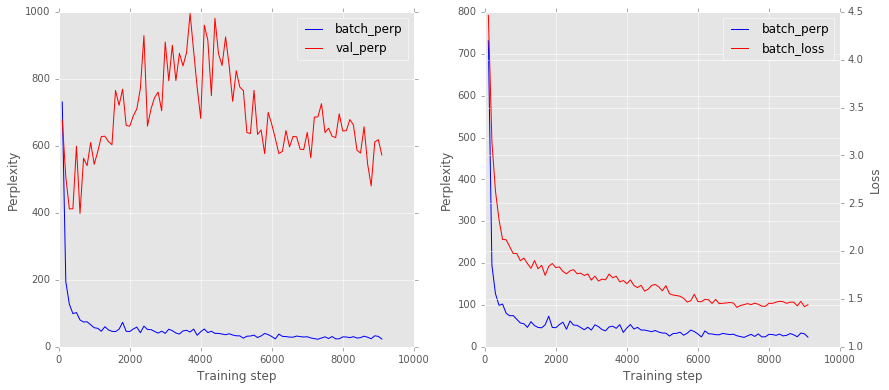

In [50]:
plot_log(loss_log, perp_log, val_perp_log)  # same weights for encoder and decoder

### Exp 3: different weights, one layer, reverse order

In [92]:
## With embedding layer

num_nodes = 128
embedding_dim = 128
num_sampled = 64  # Number of negative examples to sample in softmax.

# Parameters:

# For encoder
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix_enc = weight_init(embedding_dim, num_nodes)
im_enc = weight_init(num_nodes, num_nodes)
ib_enc = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_enc = weight_init(embedding_dim, num_nodes)
fm_enc = weight_init(num_nodes, num_nodes)
fb_enc = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_enc = weight_init(embedding_dim, num_nodes)
cm_enc = weight_init(num_nodes, num_nodes)
cb_enc = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_enc = weight_init(embedding_dim, num_nodes)
om_enc = weight_init(num_nodes, num_nodes)
ob_enc = bias_init(num_nodes)

# For decoder
# Input gate: input, previous output, and bias.
ix_dec = weight_init(embedding_dim, num_nodes)
im_dec = weight_init(num_nodes, num_nodes)
ib_dec = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_dec = weight_init(embedding_dim, num_nodes)
fm_dec = weight_init(num_nodes, num_nodes)
fb_dec = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_dec = weight_init(embedding_dim, num_nodes)
cm_dec = weight_init(num_nodes, num_nodes)
cb_dec = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_dec = weight_init(embedding_dim, num_nodes)
om_dec = weight_init(num_nodes, num_nodes)
ob_dec = bias_init(num_nodes)
# Classifier weights and biases. (for sampled softmax loss)
softmax_w = weight_init(vocabulary_size, num_nodes, np.sqrt(1.0/embedding_dim))
softmax_b = tf.Variable(tf.zeros([vocabulary_size]))

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)


# Definition of the cell computation.
def enc_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_enc) + tf.matmul(o, im_enc) + ib_enc)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_enc) + tf.matmul(o, fm_enc) + fb_enc)
    update = tf.matmul(i, cx_enc) + tf.matmul(o, cm_enc) + cb_enc
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_enc) + tf.matmul(o, om_enc) + ob_enc)
    return output_gate * tf.tanh(state), state

def dec_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_dec) + tf.matmul(o, im_dec) + ib_dec)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_dec) + tf.matmul(o, fm_dec) + fb_dec)
    update = tf.matmul(i, cx_dec) + tf.matmul(o, cm_dec) + cb_dec
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_dec) + tf.matmul(o, om_dec) + ob_dec)
    return output_gate * tf.tanh(state), state


# Input data.
train_data = [tf.placeholder(tf.int32, shape=[batch_size]) for _ in range(2*num_unrollings)]
train_inputs = [train_data[i] for i in range(num_unrollings)]
train_labels = [tf.reshape(train_data[i+num_unrollings], [batch_size, 1]) for i in range(num_unrollings)]

# Unrolled Seq2Seq LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds_in = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
embeds_lab = [tf.nn.embedding_lookup(embeddings, tf.reshape(bch, (batch_size,))) for bch in train_labels]
# sequence 1: encoder
for emb in embeds_in:
    output, state = enc_lstm_cell(emb, output, state)
# sequence 2: decoder
output, state = dec_lstm_cell(emb, output, state)
for emb in embeds_lab:
    output, state = dec_lstm_cell(emb, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_w, softmax_b, tf.concat(0, outputs),
                                  tf.concat(0, train_labels), num_sampled, vocabulary_size))

# Optimizer.
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  
# note: 
#   tf.train.optimizer.minimize() same as tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()

# Predictions.
logits = tf.matmul(tf.concat(0, outputs), tf.transpose(softmax_w)) + softmax_b
train_prediction = tf.nn.softmax(logits)

'''
# Sampling and validation eval: batch 1, no unrolling.
sample_input = tf.placeholder(tf.int32)  # one sample character
sample_embed = tf.nn.embedding_lookup(embeddings, sample_input)
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output, sample_state = lstm_cell(
    sample_embed, saved_sample_output, saved_sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
'''

# Sampling and validation eval: batch 1.
sample_inputs = [tf.placeholder(tf.int32) for _ in range(val_seq_len)]  # one sample sequence
#sample_embeds_in = [tf.nn.embedding_lookup(embeddings, inp) for inp in sample_inputs]
#sample_inputs = tf.placeholder(tf.int32, shape=[val_seq_len])  # one sample sequence
#sample_embeds_in = tf.nn.embedding_lookup(embeddings, sample_inputs)
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output = saved_sample_output
sample_state = saved_sample_state
sample_predictions = list()
next_in_idces = list()
# sequence 1
for inp in sample_inputs:
    sample_embed = tf.nn.embedding_lookup(embeddings, inp)
    sample_output, sample_state = enc_lstm_cell(sample_embed, sample_output, sample_state)
sample_prediction = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
sample_predictions.append(sample_prediction)
next_in_idx = tf.multinomial(sample_prediction, 1)[0]
next_in_idces.append(next_in_idx[0])
next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)
# sequence 2
for i in range(val_seq_len-1):
    sample_output, sample_state = dec_lstm_cell(next_in, sample_output, sample_state)
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)
    sample_predictions.append(sample_prediction)
    next_in_idx = tf.multinomial(sample_prediction, 1)[0]
    next_in_idces.append(next_in_idx[0])
    next_in = tf.nn.embedding_lookup(embeddings, next_in_idx)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_predictions = tf.concat(0, sample_predictions)

In [94]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        in_batches = train_batches.next()
        in_batches = in_batches[::-1]
        label_batches = trn_out_bches.next()
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_data[i]] = in_batches[i]
            feed_dict[train_data[i+num_unrollings]] = label_batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate([batch2array(bch) for bch in label_batches])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                sents = ['a good day', 'helloworld', 'what a net']
                for sent in sents:
                    print('Input sequence:', sent)
                    inp = [bichar2id[sent[2*i]+sent[2*i+1]] for i in range(len(sent)/2)][::-1]
                    feed_dict = {sample_inputs[i]: [inp[i]] for i in range(len(inp))}
                    out_idces, predictions = session.run([next_in_idces, sample_predictions], feed_dict=feed_dict)
                    sentence = ''.join(characters(predictions))
                    sentence_prob = ''.join([id2bichar[idx] for idx in out_idces])
                    print('Output sequence:', sentence)
                    print('Output sequence (from prob.):', sentence_prob)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size // (2*val_seq_len)):
                val_in_b = valid_batches.next()
                val_in_b = val_in_b[::-1]
                val_lab_b = val_out_bches.next()
                feed_dict = {sample_inputs[i]: val_in_b[i] for i in range(val_seq_len)}
                predictions = sample_predictions.eval(feed_dict)
                val_labels = np.concatenate([batch2array(bch) for bch in val_lab_b])
                valid_logprob = valid_logprob + logprob(predictions, val_labels)
            val_perp = float(np.exp(valid_logprob / (valid_size // (2*val_seq_len))))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)
            valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
            val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 4.160322, learning rate: 10.000000
Minibatch perplexity: 735.02
Input sequence: a good day
Output sequence:  e ere ebm
Output sequence (from prob.): anqrojhzbo
Input sequence: helloworld
Output sequence:  e e e ein
Output sequence (from prob.): ydhswxjwrn
Input sequence: what a net
Output sequence:  ereta eno
Output sequence (from prob.): gbisy hqtr
Validation set perplexity: 693.04
Average loss at step 100: 3.218219, learning rate: 10.000000
Minibatch perplexity: 210.11
Validation set perplexity: 370.84
Average loss at step 200: 2.648491, learning rate: 10.000000
Minibatch perplexity: 103.70
Validation set perplexity: 348.13
Average loss at step 300: 2.302285, learning rate: 10.000000
Minibatch perplexity: 81.35
Validation set perplexity: 291.08
Average loss at step 400: 2.038284, learning rate: 10.000000
Minibatch perplexity: 89.09
Validation set perplexity: 369.24
Average loss at step 500: 1.989207, learning rate: 10.000000
Mini

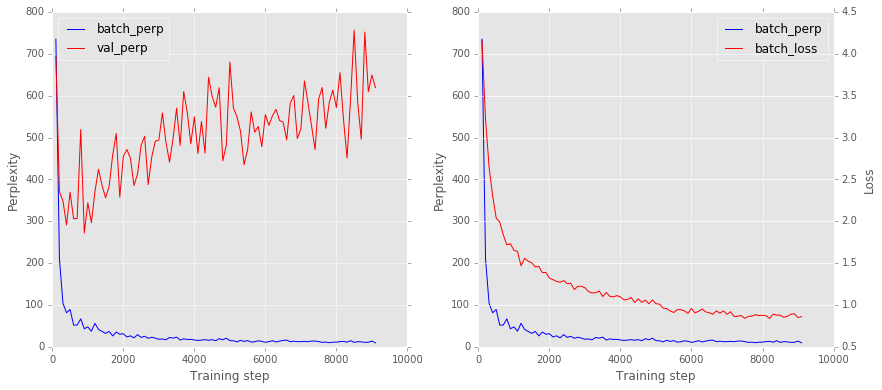

In [95]:
plot_log(loss_log, perp_log, val_perp_log)  # same weights for encoder and decoder

In [ ]:
class LSTMcell():
    
    def __init__(self, input_dim, num_nodes):
        # Input gate: input, previous output, and bias.
        self.ix = weight_init(input_dim, num_nodes)
        self.im = weight_init(num_nodes, num_nodes)
        self.ib = bias_init(num_nodes)
        # Forget gate: input, previous output, and bias.
        self.fx = weight_init(input_dim, num_nodes)
        self.fm = weight_init(num_nodes, num_nodes)
        self.fb = bias_init(num_nodes)
        # Memory cell: input, state and bias.                             
        self.cx = weight_init(input_dim, num_nodes)
        self.cm = weight_init(num_nodes, num_nodes)
        self.cb = bias_init(num_nodes)
        # Output gate: input, previous output, and bias.
        self.ox = weight_init(input_dim, num_nodes)
        self.om = weight_init(num_nodes, num_nodes)
        self.ob = bias_init(num_nodes)
        # Variables saving state across unrollings.
        self.saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
        self.saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    
    
    def memorize(self, i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, self.ix) + tf.matmul(o, self.im) + self.ib)
        forget_gate = tf.sigmoid(tf.matmul(i, self.fx) + tf.matmul(o, self.fm) + self.fb)
        update = tf.matmul(i, self.cx) + tf.matmul(o, self.cm) + self.cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, self.ox) + tf.matmul(o, self.om) + self.ob)
        
        return output_gate * tf.tanh(state), state
    
    
    def forwardPropagate(self, inputs, saved_output=None, saved_state=None):
        # Unrolled LSTM loop.
        self.outputs = list()
        if saved_output and saved_state:
            self.saved_output = saved_output
            self.saved_state = saved_state
        output = self.saved_output
        state = self.saved_state
        # forward propagate into LSTM cells
        for inp in inputs:
            output, state = self.memorize(inp, output, state)
            self.outputs.append(output)
        self.saved_output = output
        self.saved_state = state
        

    def generate(self, _input, saved_output=None, saved_state=None):
        if saved_output and saved_state:
            self.saved_output = saved_output
            self.saved_state = saved_state
        output = self.saved_output
        state = self.saved_state
        output, state = self.memorize(_input, output, state)
        self.saved_output = output
        self.saved_state = state
    
    
    def resetState(self):
        self.saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
        self.saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)

In [ ]:
embeds_in = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
embeds_lab = [tf.nn.embedding_lookup(embeddings, tf.reshape(bch, (batch_size,))) for bch in train_labels]

# OOP design guideline:
# decide main architecture and main function (write down your concepts, blueprints)
# make plan of encap to class structures (members and methods)
# input arguments arangement

class Seq2seq():
    
    def __init__(self, embedding_dim=32, num_nodes=64):
        # num_sampled: number of negative examples to sample in softmax.
        # Embedding layer
        self.embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
        
        # Classifier weights and biases. (for sampled softmax loss)
        self.softmax_w = weight_init(vocabulary_size, num_nodes, np.sqrt(1.0/embedding_dim))
        self.softmax_b = tf.Variable(tf.zeros([vocabulary_size]))
        
        # Build sequence encoder and sequence decoder
        self.encoder = LSTMcell(embedding_dim, num_nodes)
        self.decoder = LSTMcell(embedding_dim, num_nodes)
    
    
    def feedForward(self, inputs, labels, num_sampled=64):
        # sequence 1: encoder
        self.encoder.forwardPropagate(inputs)
        # sequence 2: decoder
        self.decoder.forwardPropagate(labels, self.encoder.saved_output, self.encoder.saved_state)
        
        # stateful model: to learn also the relation between each batch
        self.encoder.saved_output = self.decoder.saved_output
        self.encoder.saved_state = self.decoder.saved_state
        
        # Classifier.
        self.loss = tf.reduce_mean(
            tf.nn.sampled_softmax_loss(self.softmax_w, self.softmax_b, 
                                       tf.concat(0, self.decoder.outputs), 
                                       tf.concat(0, labels), num_sampled, vocabulary_size))
        
        
    def optimize(self, inputs, labels):
        feedForward(inputs, labels)
        
        # Optimizer.
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(
            10.0, global_step, 5000, 0.1, staircase=True)
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        #learning_rate = tf.train.exponential_decay(
        #    0.001, global_step, 5000, 0.1, staircase=True)
        #optimizer = tf.train.AdagradOptimizer(learning_rate)
        #optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        # note: 
        #   tf.train.optimizer.minimize() same as 
        #   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
        # So here we clip the gradients to avoid explosion problem
        gradients, v = zip(*optimizer.compute_gradients(self.loss))
        gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
        optimizer = optimizer.apply_gradients(
            zip(gradients, v), global_step=global_step)  
        
        # Predictions.
        logits = tf.matmul(tf.concat(0, self.decoder.outputs), 
                           tf.transpose(self.softmax_w)) + self.softmax_b
        self.train_prediction = tf.nn.softmax(logits)
        
        
    def fit_generator(self, data, num_steps=9001):
        src_batches = data[0]
        target_batches = data[1]
        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)
        for step in range(num_steps):
            inp_batches = src_batches.next()
            
        feed_dict = dict()
    
    
    def encDec(self, inputs):
        # sequence 1: encoder
        self.encoder.forwardPropagate(inputs)


In [94]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        in_batches = train_batches.next()
        in_batches = in_batches[::-1]
        label_batches = trn_out_bches.next()
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_data[i]] = in_batches[i]
            feed_dict[train_data[i+num_unrollings]] = label_batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate([batch2array(bch) for bch in label_batches])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                sents = ['a good day', 'helloworld', 'what a net']
                for sent in sents:
                    print('Input sequence:', sent)
                    inp = [bichar2id[sent[2*i]+sent[2*i+1]] for i in range(len(sent)/2)][::-1]
                    feed_dict = {sample_inputs[i]: [inp[i]] for i in range(len(inp))}
                    out_idces, predictions = session.run([next_in_idces, sample_predictions], feed_dict=feed_dict)
                    sentence = ''.join(characters(predictions))
                    sentence_prob = ''.join([id2bichar[idx] for idx in out_idces])
                    print('Output sequence:', sentence)
                    print('Output sequence (from prob.):', sentence_prob)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size // (2*val_seq_len)):
                val_in_b = valid_batches.next()
                val_in_b = val_in_b[::-1]
                val_lab_b = val_out_bches.next()
                feed_dict = {sample_inputs[i]: val_in_b[i] for i in range(val_seq_len)}
                predictions = sample_predictions.eval(feed_dict)
                val_labels = np.concatenate([batch2array(bch) for bch in val_lab_b])
                valid_logprob = valid_logprob + logprob(predictions, val_labels)
            val_perp = float(np.exp(valid_logprob / (valid_size // (2*val_seq_len))))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)
            valid_batches = BatchGenerator(valid_text, 1, val_seq_len)
            val_out_bches = BatchGenerator(val_label_text, 1, val_seq_len)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 4.160322, learning rate: 10.000000
Minibatch perplexity: 735.02
Input sequence: a good day
Output sequence:  e ere ebm
Output sequence (from prob.): anqrojhzbo
Input sequence: helloworld
Output sequence:  e e e ein
Output sequence (from prob.): ydhswxjwrn
Input sequence: what a net
Output sequence:  ereta eno
Output sequence (from prob.): gbisy hqtr
Validation set perplexity: 693.04
Average loss at step 100: 3.218219, learning rate: 10.000000
Minibatch perplexity: 210.11
Validation set perplexity: 370.84
Average loss at step 200: 2.648491, learning rate: 10.000000
Minibatch perplexity: 103.70
Validation set perplexity: 348.13
Average loss at step 300: 2.302285, learning rate: 10.000000
Minibatch perplexity: 81.35
Validation set perplexity: 291.08
Average loss at step 400: 2.038284, learning rate: 10.000000
Minibatch perplexity: 89.09
Validation set perplexity: 369.24
Average loss at step 500: 1.989207, learning rate: 10.000000
Mini

In [ ]:
model = Seq2seq()